# Run simple FACET-II Linac simulation

# Set up environment variables and import functions

In [1]:
from pytao import Tao
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
import math
from os import path,environ
import os
import pandas as pd

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles
import subprocess

# Set environment variable - needed for lattice_init
#%env FACET2_LATTICE /Users/cemma/Downloads/facet2-lattice
%env FACET2_LATTICE /sdf/home/s/sanjeev/github/facet2-lattice

print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 
# Note that you can't put a comment at the end of the magic line, jupyter doesn't read it as a comment

# Load helper functions
#%run /Users/cemma/Documents/Work/FACET-II/Bmad_sims/BmadHelperFunctions.ipynb
%run /sdf/home/s/sanjeev/github/bmad/l1_l2_phase_scan/BmadHelperFunctions.ipynb

env: FACET2_LATTICE=/sdf/home/s/sanjeev/github/facet2-lattice
Make sure enviornment was set!:   /sdf/home/s/sanjeev/github/facet2-lattice


# Start Tao, set Linac Phases and plot Twiss Functions

In [2]:
tao=Tao('-init {:s}/bmad/models/f2_elec/taoCEedit.init -noplot'.format(environ['FACET2_LATTICE'])) 

In [3]:
# Load floorplan and plot Twiss
elements=tao.lat_ele_list();
#tao.lat_list(elements[0],'ElementType')
tao.ele_gen_attribs(elements[0]);

floorplan=pd.read_csv(io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), sep="[\s\n]+",engine='python',
            names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)
floorplan[::25].head(7);

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3899098/3273526228.py:6: SyntaxWarning: invalid escape sequence '\s'
  floorplan=pd.read_csv(io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), sep="[\s\n]+",engine='python',


In [4]:
# Display all the rf cavity elements
floorplan[floorplan.ElementType.str.contains('cavity')][::1].head(10);
# Display all Bunch Compressor elements
floorplan[floorplan.ElementName.str.contains('BC')][::1].head(670);

In [5]:
# Find element strings matching L1, L2 and L3
#These more general match strings might cause problems by including both lords and slaves!
L1MatchStrings = ["K11_1*", "K11_2*"]
L2MatchStrings = ["K11_4*", "K11_5*", "K11_6*", "K11_7*", "K11_8*", "K12_*", "K13_*", "K14_*"]
L3MatchStrings = ["K15_*", "K16_*", "K17_*", "K18_*", "K19_*"]

#Therefore, use lat_list and these general search strings to get specific elements
#Recall that, by default, lat_list has the flag "-track_only" so lords are not included
#But some of the tracking elements are super_slaves which cannot be `set`

#"-array_out" flag is on by default but if flags are edited, need to re-add manually to get numeric values back

L1MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L1MatchStrings ] )
L2MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L2MatchStrings ] )
L3MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L3MatchStrings ] )

# Define energy setpoints at exit of L0 L1 L2 in eV
L0energy = 0.125e9;    
L1energy = 0.338e9;
L2energy = 4.5e9;

# Define L1 and L2 phases in deg
L1phase = -17;
L2phase = -41.5;

# Phase L1
setLinacPhase(L1MatchStrings, L1phase)
setLinacGradientAuto( L1MatchStrings, L1energy - L0energy )

# Phase L2
setLinacPhase(L2MatchStrings, L2phase)
setLinacGradientAuto( L2MatchStrings, L2energy - L1energy )

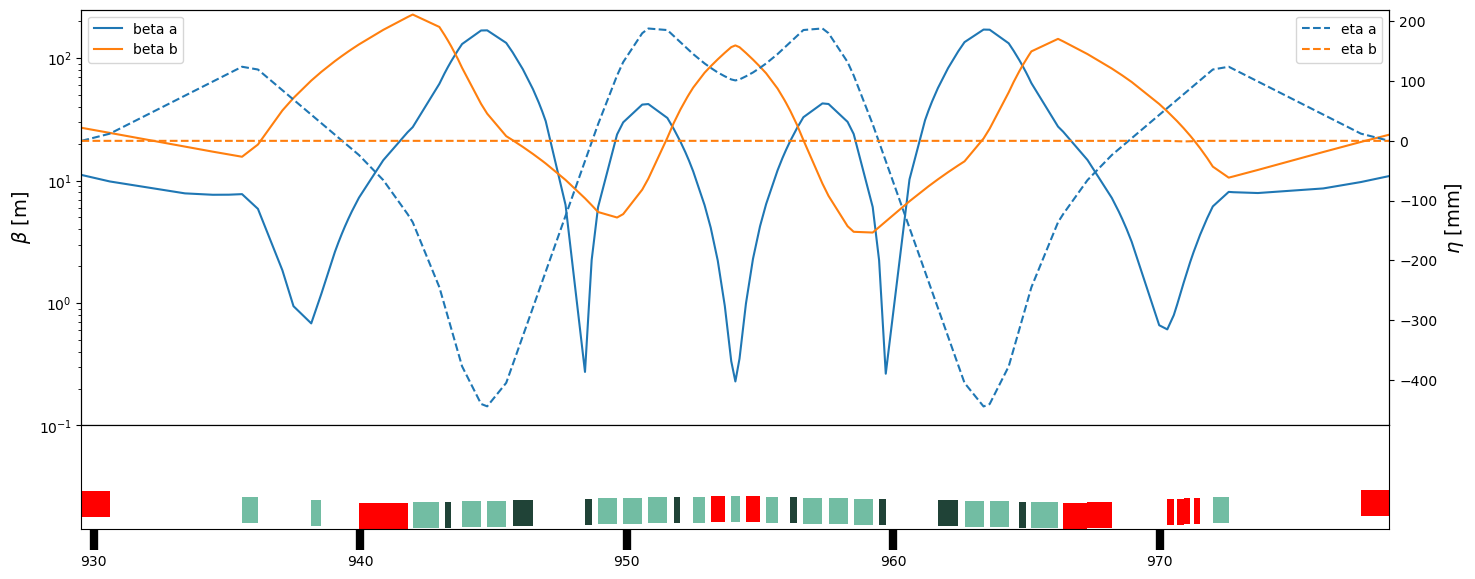

In [6]:
#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
alpha_x=np.array([tao.lat_list(x,'ele.a.alpha')[0] for x in floorplan.Index])
alpha_y=np.array([tao.lat_list(x,'ele.b.alpha')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])

#Plot twiss functions 
fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta a')
ax.semilogy(s,beta_y,label='beta b')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta a')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta b')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=tao.ele_head('BEGBC20')['s']
zmax=tao.ele_head('ENDBC20')['s']

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig(savefolder+'beamline'+savestem,transparent=False,bbox_inches='tight')

# Track particles through the lattice

In [7]:
# Set the number of macro-particles
tao.cmd('set beam_init n_particle = 10000'); # limit to 10k particles for now

# Change the staring input beam to a S2E beam obtained from IMPACT 
# tao.cmd('set beam_init position_file=L0AFEND_matched.h5')# IF you want to change the beam to the new matched beam at the start
# tao.cmd('reinit beam')

# Change the starting beam to a matched Gaussian distribution with known charge and sigz
tao.cmd('set beam_init sig_z=0.78e-3')
tao.cmd('set beam_init bunch_charge=2e-9')
tao.cmd('reinit beam')

[]

In [8]:
# Activate CSR and run particle tracking

tao.cmd('call Activate_CSR[44].tao');
#tao.cmd('csron') #only works once we define the alias "csroff" in the next section.
tao.cmd('csroff') #only works once we define the alias "csroff" in the next section.
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

[]

# Plot results

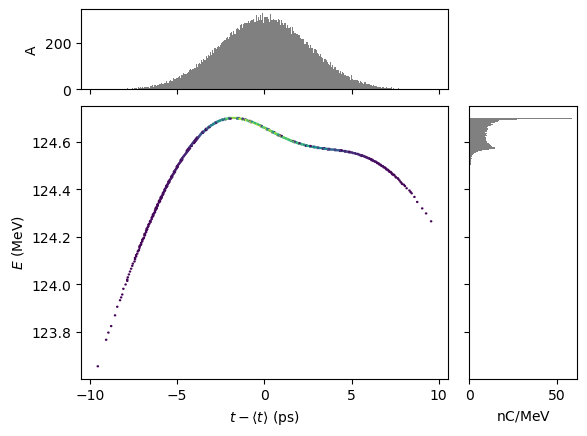

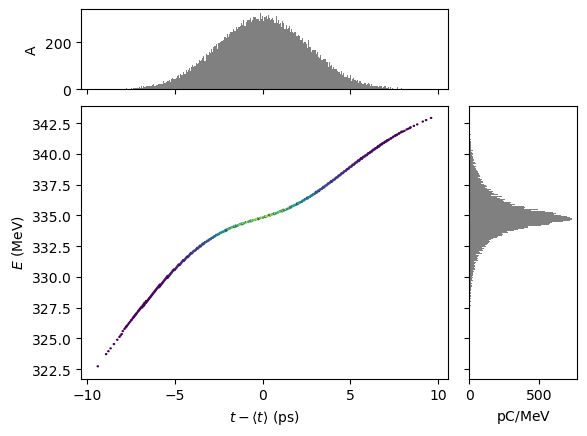

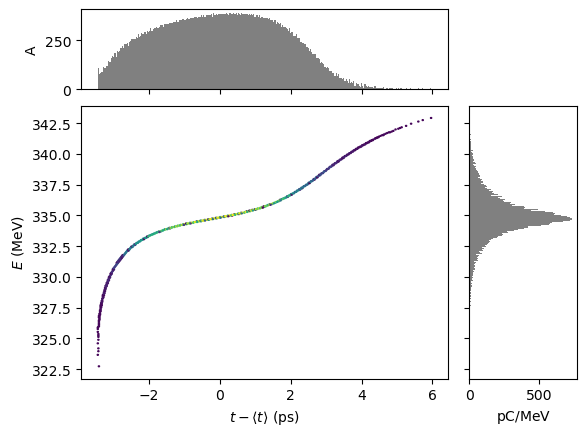

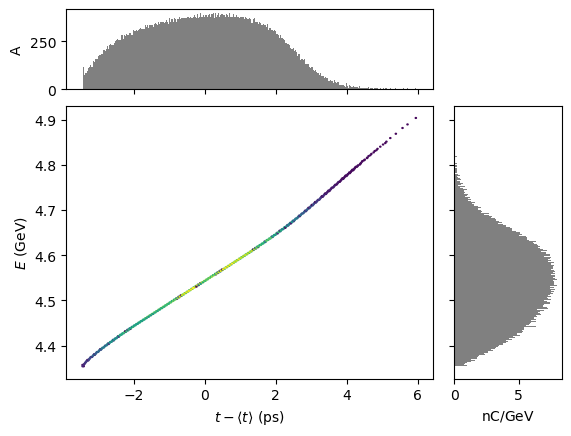

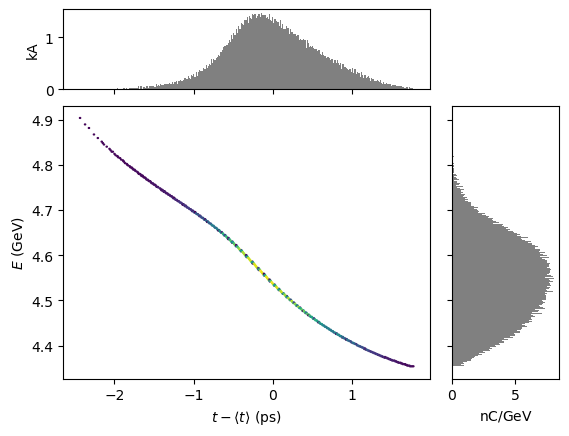

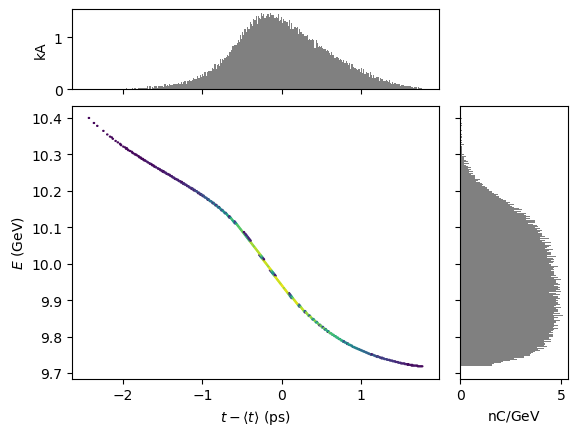

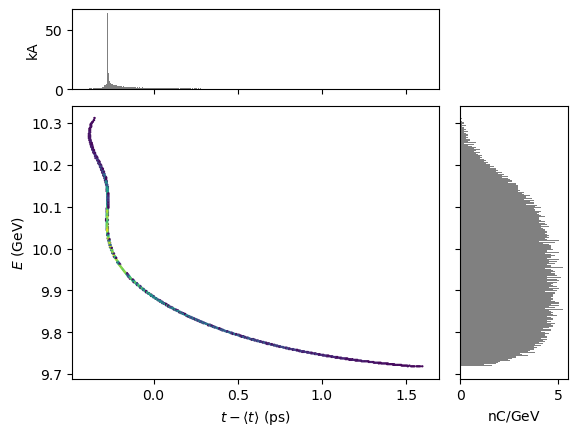

In [9]:
# Plot LPS at different locations
locations = ['L0BFEND','BC11CBEG','BC11CEND',
             'BEGBC14_1','ENDBC14_2','BEGBC20','PENT'];

for location in locations:
    P = ParticleGroup(data=tao.bunch_data(location))
    # Select out live particles
    P = P[P.status==1]
    P.drift_to_z()
    # General lPS plot and transverse profile
    P.plot('delta_t', 'energy',bins=300)

1.23756882755272e-12
{'alpha_x': -0.45940470374355735, 'beta_x': 1.0264341762979194, 'gamma_x': 1.1798639501557295, 'emit_x': 7.359030737889368e-09, 'eta_x': 0.008947074548724192, 'etap_x': -0.0014287170896348314, 'norm_emit_x': 0.00014340396510464164}
{'alpha_y': -0.4172796121331635, 'beta_y': 0.5084885427377116, 'gamma_y': 2.3090437168564457, 'emit_y': 1.8392559311566693e-10, 'eta_y': 8.487303093694435e-07, 'etap_y': 5.127286387620948e-07, 'norm_emit_y': 3.5841213709312995e-06}


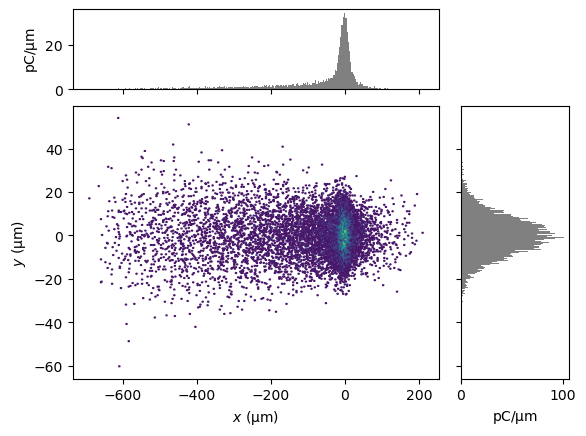

In [10]:
# Plot the transverse spot at IP
P = ParticleGroup(data=tao.bunch_data('PENT'))
# Select out live particles
P = P[P.status==1]
P.drift_to_z()
# General lPS plot and transverse profile
P.plot('x', 'y',bins=300)
stats = tao.bunch_params('PENT')
print(stats['sigma_t'])
print(P.twiss('x'))
print(P.twiss('y'))

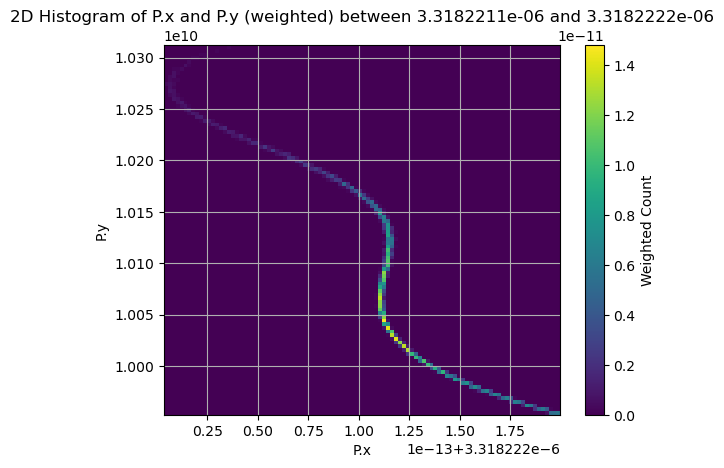

In [11]:
# Plot the slice emittance and current profile
P = ParticleGroup(data=tao.bunch_data('PENT'))
# Select out live particles
P = P[P.status==1]
P.drift_to_z()
# Define minz and maxz
mint = 1.1e-12+3.31822e-6
maxt = 2.2e-12+3.31822e-6

# Filter P.x for values between minx and maxx
filtered_indices = np.where((P.t >= mint) & (P.t <= maxt))
filtered_P_x = P.t[filtered_indices]
filtered_P_y = P.pz[filtered_indices]
filtered_charge = P.weight[filtered_indices]

# 2d Hist filtered data
plt.hist2d(filtered_P_x, filtered_P_y, weights = filtered_charge,bins=100, cmap='viridis')
plt.colorbar(label='Weighted Count')
plt.xlabel('P.x')
plt.ylabel('P.y')
plt.title(f'2D Histogram of P.x and P.y (weighted) between {mint} and {maxt}')
plt.grid(True)
plt.show()

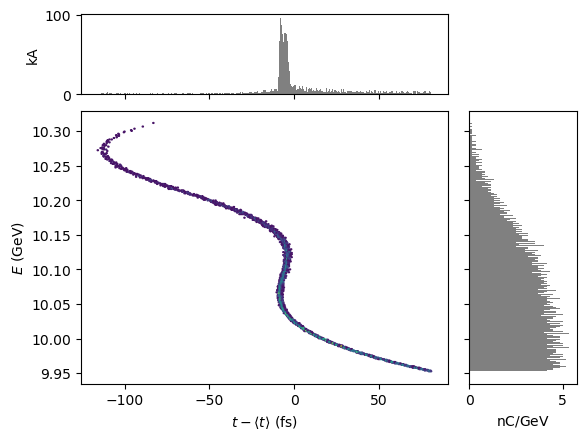

In [12]:
P = P[filtered_indices]
P.plot('delta_t', 'energy',bins=300)

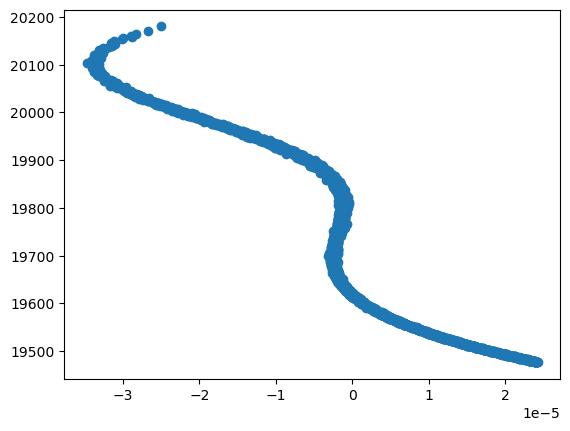

/sdf/home/s/sanjeev/miniforge3/envs/bmad/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/sdf/home/s/sanjeev/miniforge3/envs/bmad/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


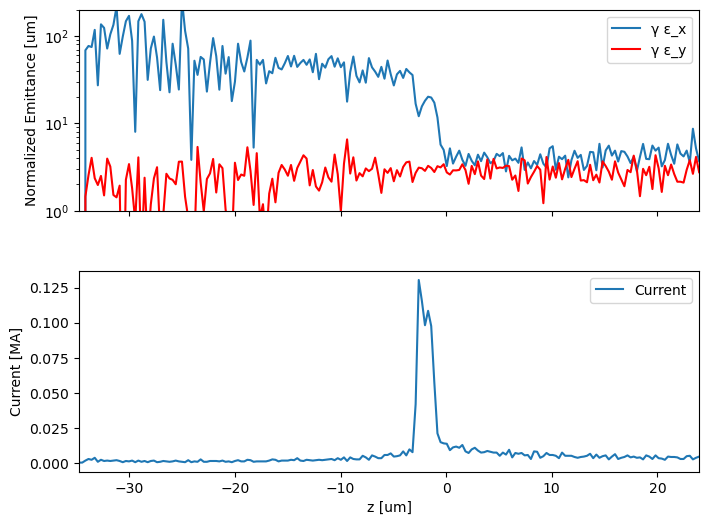

In [13]:
gamma = P.energy/0.511e6;
z = (P.t-np.mean(P.t))*3e8;
nslices = 200;
plt.scatter(z,gamma)
plt.show()
emitx, emity, slicez, slicebunchingfactor, current = calculate_slice_emittance(P.x, P.xp, P.y, P.yp, z, gamma, nslices, -1.0*P.charge)